#### Mask RNN 

### Input
- Image

### Target
- Boxes of objects
- Labels
- Mask data  

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 10, 7: 10, 8: 4, 9: 6}


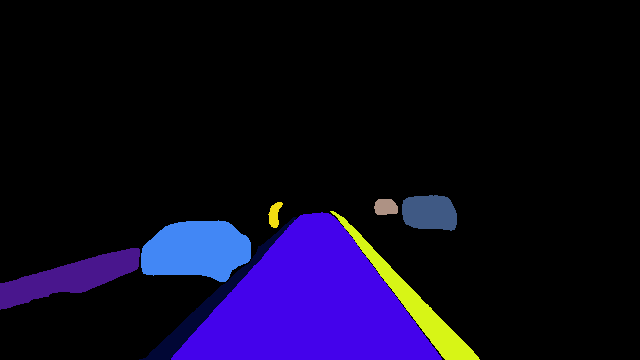

In [5]:
from PIL import Image
import yaml
import os
import numpy as np
from label_manager import LabelManager
import label_manager
import torch
import cv2

obj_entity_list = []
obj_entity_list.append({'Entity': 'Background', 'ID': 0, 'Colour': [0,0,0]})


label_mgr = LabelManager()
idx = 80
in_img = Image.open('rev_input/{}.jpg'.format(idx))
mask_img = Image.open('rev_mask/{}.png'.format(idx))
mask = np.array(mask_img)
obj_ids = np.unique(mask)

with open("object.yaml", 'r') as file:
    config = yaml.safe_load(file)
    for ele in config['DRIVING_objects']:
        entity_map = {}
        entity_map['Entity'] = ele['Entity']
        entity_map['ID'] = ele['ID']
        entity_map['Colour'] = ele['Colour']
        obj_entity_list.append(entity_map)


labels = label_manager.parse_label('rev_mask/{}.yaml'.format(idx))

colour_list = []
for i, entity in enumerate(obj_entity_list):
    cur_colour = entity['Colour']
    colour_list+=cur_colour
    if (i >= len(obj_ids) + 1):
        break

print(labels)

mask_img.putpalette(colour_list)
mask_img


### Prepare the target data

boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

labels (Int64Tensor[N]): the class label for each ground-truth box

masks (UInt8Tensor[N, H, W]): the segmentation binary masks for each instance

[0 1 3 4 5 6 7 8 9]
masks (8, 360, 640)


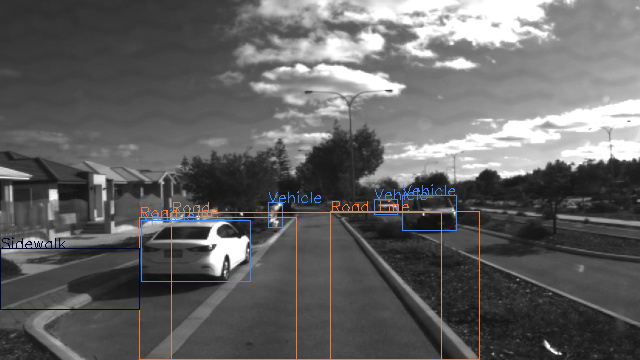

In [6]:
label_mgr = LabelManager()
idx = 80
in_img = Image.open('rev_input/{}.jpg'.format(idx))
mask_img = Image.open('rev_mask/{}.png'.format(idx))
mask = np.array(mask_img)

# labels = label_manager.parse_label('rev_mask/{}.yaml'.format(idx))
with open('rev_mask/{}.yaml'.format(idx), 'r') as file:
        target_label = yaml.safe_load(file)



obj_ids = np.unique(mask)
# first id is the background, so remove it
print(obj_ids)
obj_ids = obj_ids[1:]
masks = mask == obj_ids[:, None, None]
print('masks', masks.shape)
num_objs = len(obj_ids)
img_array = np.array(in_img)

labels =[]
for i in obj_ids:
    label = target_label[i]
    labels.append(label)

boxes = []
out_img = np.zeros((in_img.height, in_img.width, 4), np.uint8)
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])
    pt1 = tuple((xmin, ymin))
    pt2 = tuple((xmax, ymax))
    
    label = labels[i]
    colour = label_mgr.get_colour(label)
    name = label_mgr.get_names()[label - 1]
    #print('label: ', label, 'name:', name)

    cv2.rectangle(img_array, pt1, pt2,color=colour, thickness=1)
    cv2.putText(img_array,name, pt1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour,thickness=1)


updated_img = Image.fromarray(img_array)
updated_img

### Define training process

In the training function, create a dictionary to store losses for each training iteration. 

In [41]:
import utils
from model import get_transform, build_model
import math
import sys
from tqdm import tqdm

def train_one_epoch_v2(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    # Build a dictionary to recored losses
    LOSS = {
        'loss_classifier':[],
        'loss_box_reg':[],
        'loss_mask':[],
        'loss_objectness':[],
        'loss_rpn_box_reg':[],
        'loss_sum':[]
    }

    lr_scheduler = None
    # Warm up the model in the first epoch
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # Training process
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        for i in loss_dict.keys():
            LOSS[i].append(loss_dict[i].item())    
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        LOSS['loss_sum'].append(loss_value)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    return LOSS

### Define Validating process



In [42]:
from tqdm import tqdm
def val_one_epoch(model, data_loader, device, epoch):
    # Build a dictionary to recored losses
    LOSS = {
        'val_loss_classifier':[],
        'val_loss_box_reg':[],
        'val_loss_mask':[],
        'val_loss_objectness':[],
        'val_loss_rpn_box_reg':[],
        'val_loss_sum':[]
    }
    
    # Speed up evaluation by not computing gradients
    with torch.no_grad():
        model.train()
        
        # Evaluating process
        for images, targets in tqdm(data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            for i in loss_dict.keys():
                LOSS["val_"+i].append(loss_dict[i].item())    
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            LOSS['val_loss_sum'].append(loss_value)

    return LOSS

### Start Training

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch, evaluate
from rev_dataset import RevDataset
import utils
from model import get_transform, build_model
from label_manager import LabelManager

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

label_manager = LabelManager()
# add background
label_num = label_manager.get_num() + 1

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=label_num,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = label_num
# use our dataset and defined transformations
dataset = RevDataset('REV', get_transform(train=True))
dataset_test = RevDataset('REV', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = build_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 5 epochs
num_epochs = 10

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    loss = train_one_epoch_v2(model, optimizer, data_loader, device, epoch, print_freq=10)
    train_losses.append(loss)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    loss = val_one_epoch(model, data_loader_test, device, epoch)
    test_losses.append(loss)
    print('')

print("That's it!")

# torch.save(model, 'mask-rcnn-pedestrian.pt')

### Plot Losses

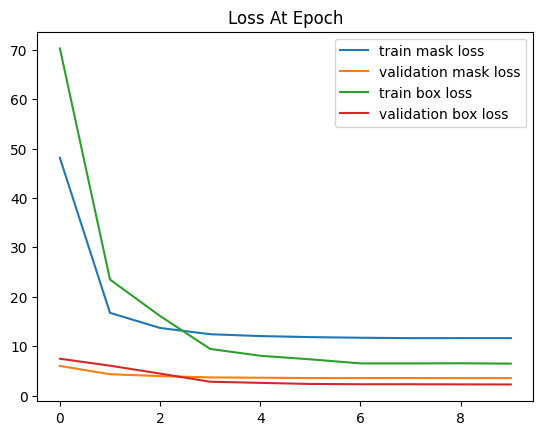

In [47]:
from PIL import Image
from matplotlib import pyplot as plt

loss_mask = []
loss_mask_val = []
box_mask = []
box_mask_val = []

for l in train_losses:
    c_loss = l['loss_mask']
    #print(sum(c_loss))
    loss_mask.append(sum(c_loss))
    c_loss = l['loss_box_reg']
    #print(sum(c_loss))
    box_mask.append(sum(c_loss))

for l in test_losses:
    c_loss = l['val_loss_mask']
    loss_mask_val.append(sum(c_loss))
    c_loss = l['val_loss_box_reg']
    #print(sum(c_loss))
    box_mask_val.append(sum(c_loss))

plt.plot(loss_mask, label = 'train mask loss')
plt.plot(loss_mask_val, label = 'validation mask loss')
plt.plot(box_mask, label = 'train box loss')
plt.plot(box_mask_val, label = 'validation box loss')
plt.title('Loss At Epoch')
plt.legend()
#print(train_losses[3]['loss_box_reg'])


